In [1]:
#Add folder to sys path to import modules from sub folders
import sys
sys.path.insert(0, r'C:\Users\SaANTIAGO\Google Drive Streaming\My Drive\18_UT_RAPID\cuttings_sensor')

In [2]:
# from src.text_extraction import *
from src.file_dialog import *
import numpy as np
# import cv2
# from tkinter import Tk, filedialog
# from pathlib import Path
# import os
# from os import listdir
# from os.path import isfile, join
# from PIL import Image, ImageEnhance, ImageOps, ImageFilter
# import PIL.Image
# import pytesseract
# pytesseract.pytesseract.tesseract_cmd = Path(r'C:\Program Files\Tesseract-OCR\tesseract.exe') #Set Pytesseract path
# #import keras_ocr
import pandas as pd
# import datetime

import matplotlib.pyplot as plt

In [45]:
def get_outliers_array(df, col: 'str', low_limit: float):
    """Store outliers into string array, used to later replace values.
    Returns string array of outlier numbers
    df: dataframe
    col: column from dataframe (as str)
    low_limit: float, set as minimum level for outliers
    """
    #Get outliers array from column
    outliers = df[col][df[col] > low_limit]
    #Get anomalies
    num_array = []
    for i in np.arange(0, len(outliers)):
        try:
            num = str(outliers[i]).split('2')[0] #Split 0.8002672 into 0.800 and 672
            if (len(num) < 6) & (not(num[-1] == '3')): #Biggest lenght in faulty OCR figs. is 0.800 which len < 6
                num_array.append(num)
        except:
            next

    for i in np.arange(0, len(outliers)):
        try:
            num = str(outliers[i]).split('3')[0]
            if (len(num) < 6) & (not(num[-1] == '2')):
                num_array.append(num)
        except:
            next
    #Get unique values
    num_array = np.unique(np.array(num_array))
    #Sort array based value and larger strings
    num_array = np.sort(num_array)[::-1] #Get array from biggest numbers and longest strings ['0.9', '0.800', '0.80', etc]
    # num_array = sorted(list(num_array), key=len, reverse=True)
    # num_array = np.array(num_array)
    return num_array

def replacement_array(num_array, string_replacement: str):
    """Return replacement array as string list ['0.00', '0.00', etc].
    """
    # Find the length of each element
    arr_len = np.array([len(i) for i in num_array])
    #Generate replacement array
    cond = [arr_len > 4, arr_len > 3, arr_len > 2]
    choices = [string_replacement, string_replacement, string_replacement]
    num_array_replace = np.select(cond, choices)
    return num_array_replace

def filter_outliers(df, col: str, num_array, threshold: float):
    """Filter and replace outliers in defective OCR.
    Returns column with replaces outliers
    df: dataframe
    col: column in df
    num_array: ouliers array    
    """

    #Set both arrays as strings
    df[col] = df[col].astype(str)
    num_array = list(num_array.astype(str))
    for i in np.arange(0, len(num_array)):
        try:
            #Search on first 5 characters of string
            cond_1 = (df[col].astype(str).str.slice(0, 5).str.contains(num_array[i]))
            #Only values higher than num_array element
            cond_2 = (df[col].astype(float) >= num_array[i].astype(float))
            mask = cond_2 & cond_1
            #Replace num_Array element in string
            df[col][mask] = df[col][mask].astype(str).str.replace(num_array[i], num_array_replace[i])
        except:
            next
    #Convert to float, and coerce errors (for those elements with errors or NaNs)
    df[col] = pd.to_numeric(df[col], errors = 'coerce')
    return df[col]

In [4]:
def remove_outliers_iqr(df, col):
    #Replace outliers
    first_q = df[col].quantile(0.25)
    third_q = df[col].quantile(0.75)
    #mean_q = df[col].mean()
    iqr = third_q - first_q
    low_limit = first_q - 1.5*iqr
    high_limit = third_q + 1.5*iqr
    cond_1 = (df[col] > low_limit)
    cond_2 = (df[col] < high_limit)
    mask = cond_1 & cond_2
    df[col] = df[col][mask]
    return df[col]

In [42]:
#Replace outliers in laser_measurement (due to odd OCR interpretation)
video_data = pd.read_csv(get_data_file('Select Video Data File'), index_col=0)
video_data['time_index'] = pd.to_datetime(video_data['time_index'])

In [43]:
num_array = get_outliers_array(video_data, 'laser_measurement', low_limit=0.009)
num_array_replace = replacement_array(num_array, string_replacement='0.00')

In [46]:
video_data['laser_measurement'] = filter_outliers(video_data, 'laser_measurement', num_array, 0.05)

<ipython-input-45-86985567c0bc>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][mask] = df[col][mask].astype(str).str.replace(num_array[i], num_array_replace[i])


ValueError: could not convert string to float: '0.0030.001'

In [37]:
np.isin(np.unique([video_data['laser_measurement'] > 0.015]), True)

array([False,  True])

In [40]:
np.any(np.unique([video_data['laser_measurement'] > 0.015]) == True)

True

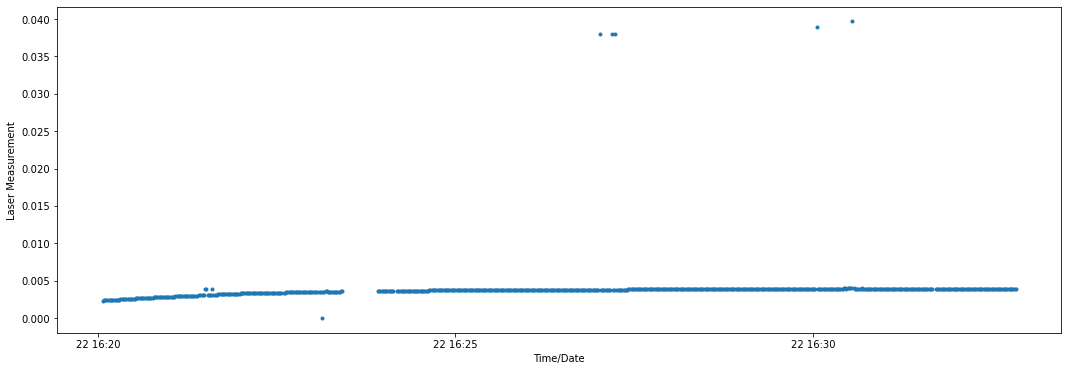

In [28]:
#Plot Data to check outliers
plt.figure(figsize=(18, 6))
plt.plot(video_data['time_index'], video_data['laser_measurement'], '.', label ='laser_measurement')
plt.xlabel('Time/Date')
plt.ylabel('Laser Measurement')
plt.show()

In [ ]:
#Remove laser measurements outliers
video_data['laser_measurement'] = remove_outliers_iqr(video_data, 'laser_measurement')

In [ ]:
#Plot Data to check outliers
plt.figure(figsize=(18, 6))
plt.plot(video_data['time_index'], video_data['laser_measurement'], '.', label ='laser_measurement')
plt.xlabel('Time/Date')
plt.ylabel('Laser Measurement')
plt.show()

In [ ]:
#Interpolate NaNs
laser_measurement_array = video_data['laser_measurement'].interpolate(method='polynomial', order=3)
plt.figure(figsize=(18, 6))
plt.plot(video_data['time_index'], laser_measurement_array, '.')
plt.show()

In [ ]:
#Replace Column
video_data['laser_measurement'] = laser_measurement_array

In [ ]:
#Save Dataframe
df_name = 'video_2_2022_06_22_data.csv'
directory = get_directory('Select Directory to backup Video Data DF', as_path=True)
file_path = os.path.join(directory, df_name)
video_data.to_csv(file_path)

In [ ]:
save_dataframe('video_2_2022_06_22_data.csv', video_data)